In [1]:
import polars as pd
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/kaggle/input/machine-learning-template')
from ml_template.utils import KFold_Sampler, multiple_table
from ml_template.utils.confusion_matrix_pretty_print import pp_matrix_from_data
from ml_template.utils.eval_utils import *
from ml_template.model.ml_model import *
from sklearn.preprocessing import LabelEncoder
from category_encoders import MEstimateEncoder

from nltk.tokenize import (word_tokenize, MWETokenizer)
#!pip install pyspellchecker
#from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
ori_data_df = pd.read_csv('./data/regression_example/html2023-spring-final-project/train.csv')
ori_test_df = pd.read_csv('./data/regression_example/html2023-spring-final-project/test.csv')
test_partial_ans = pd.read_csv('./data/regression_example/test_partial_answer.csv')
data_df = ori_data_df.copy()
test_df = ori_test_df.copy()
combine_df = pd.concat([data_df,test_df])
label_column = 'Danceability'

In [2]:
val_df = ori_test_df[ori_test_df.id.isin(test_partial_ans.id)]
val_df[label_column] = test_partial_ans[label_column].values
test_df = test_df[~test_df.id.isin(test_partial_ans.id)]
data_df['set'] = 'train'
val_df['set'] = 'val'
test_df['set'] = 'test'
combine_df = pd.concat([data_df,val_df,test_df])

In [3]:
import category_encoders as ce
_data_df = combine_df[(combine_df.set=='train') | (combine_df.set == 'val')].copy().drop(columns=['set'])
artist_loo_encoder = ce.LeaveOneOutEncoder()
artist_loo_encoder.fit(_data_df['Artist'], _data_df.Danceability)

composer_loo_encoder = ce.LeaveOneOutEncoder()
composer_loo_encoder.fit(_data_df['Composer'], _data_df.Danceability)


album_type_loo_encoder = ce.LeaveOneOutEncoder()
album_type_loo_encoder.fit(_data_df['Album_type'], _data_df.Danceability)

channel_loo_encoder = ce.MEstimateEncoder(m=0.5)
channel_loo_encoder.fit(_data_df['Channel'], _data_df.Danceability)

Composer_Album_type_te = _data_df.groupby(['Composer','Album_type']).Danceability.mean()
Composer_Album_type_te=Composer_Album_type_te.reset_index(drop=False)

In [4]:
def label_encoder(df,columns):
    df = pd.get_dummies(df,columns=columns)
    return df

def keyword_search(df,keywords):
    df['Keyword'] = df['Description'].apply(lambda x: any([ k in x.lower()  for k in keywords]))
    return df

def target_encode(df):
    df['Artist_te'] = artist_loo_encoder.transform(df['Artist'])
    df['Composer_te'] = composer_loo_encoder.transform(df['Composer'])
    df['Album_type_te'] = album_type_loo_encoder.transform(df['Album_type'])
    # df['Channel_te'] = channel_loo_encoder.transform(df['Channel'])
    return df

def baseline_process(df,feature_columns):
    df['Album_type'] = df['Album_type'].fillna('album')
    df['Composer'] = df['Composer'].fillna('unknow')
    df['Description'] = df['Description'].fillna('')
    df['Title'] = df['Title'].fillna('')
    df['Album'] = df['Album'].fillna('')
    df['Licensed'] = df['Licensed'].fillna(df['Licensed'].median()).astype(int)
    df['official_video'] = df['official_video'].fillna(df['official_video'].median()).astype(int)
    for col in feature_columns:
        if df[col].dtype != object:
            df[col] = df[col].fillna(df[col].median())
    df = target_encode(df)
    df = label_encoder(df,['Album_type','Composer'])
    keywords = ['dance','dancing','party']
    df = keyword_search(df,keywords)
    return df

drop_feature_columns = ['Danceability', 'Description', 'Title',\
                        'Artist', 'set', 'Uri', 'Url_spotify',\
                        'Url_youtube','id','Track','Album',\
                        'Channel']
feature_columns = data_df.columns.drop(drop_feature_columns)
combine_df = baseline_process(combine_df,feature_columns)
feature_columns = combine_df.columns.drop(drop_feature_columns)
feature_columns


Index(['Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms',
       'Views', 'Likes', 'Stream', 'Licensed', 'official_video', 'Comments',
       'Artist_te', 'Composer_te', 'Album_type_te', 'Album_type_album',
       'Album_type_compilation', 'Album_type_single',
       'Composer_Finneas O'Connell', 'Composer_J. Cole', 'Composer_Juicy J',
       'Composer_Louis Bell', 'Composer_Ludwig Göransson',
       'Composer_Mike Dean', 'Composer_Noah "40" Shebib',
       'Composer_Ricky Reed', 'Composer_Terrace Martin', 'Composer_Yeti Beats',
       'Composer_unknow', 'Keyword'],
      dtype='object')

In [5]:
test_df = combine_df[combine_df.set=='test'].copy().drop(columns=['set'])
val_df = combine_df[combine_df.set=='val'].copy().drop(columns=['set'])
data_df = combine_df[(combine_df.set=='train') | (combine_df.set == 'val')].copy().drop(columns=['set'])
# data_df = combine_df[(combine_df.set=='train')].copy().drop(columns=['set'])

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,precision_recall_fscore_support, roc_auc_score, f1_score, recall_score, precision_score, mean_squared_error
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars, SGDRegressor, SGDOneClassSVM, PassiveAggressiveRegressor, PassiveAggressiveClassifier, TweedieRegressor,MultiTaskElasticNet,HuberRegressor, QuantileRegressor, TheilSenRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVR, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, XGBClassifier
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, CompoundKernel, RBF, Sum, Matern, Exponentiation, PairwiseKernel
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import lightgbm as lgb
from glob import glob
import pandas as pd
import numpy as np
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import copy
from tabpfn import TabPFNClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler

In [7]:
model_lgb = lgb.LGBMRegressor(objective='regression',
                            learning_rate=0.05, n_estimators=3000,
                           )

model_lgb_depth = lgb.LGBMRegressor(objective='regression',
                            learning_rate=0.05, n_estimators=3000,
                            max_bin = 55, bagging_fraction = 0.8,
                            bagging_freq = 10, feature_fraction = 0.2319,
                            feature_fraction_seed=9, bagging_seed=9,
                            min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                            is_unbalance=False)

model_dict = {
              #'RF_depth_None':RandomForestRegressor(n_estimators=1300,max_depth=5),
              'LGB_Reg_Depth':model_lgb_depth,
              # 'LGB_None':model_lgb,
              'MLP':MLPRegressor(activation = "relu", alpha = 0.1, hidden_layer_sizes = (100,10),
                            learning_rate = "constant", max_iter = 3000, random_state = 1000),
              #'XGB_31_3':XGBRegressor(n_estimators=31,max_depth=3),
              #'XGB_310_3':XGBRegressor(n_estimators=31,max_depth=3),
              'XGB_4':XGBRegressor(n_estimators=500,max_depth=4,colsample_bytree=0.8),
              #'XGB_2':XGBRegressor(n_estimators=500,max_depth=2,colsample_bytree=0.8),
              #'XGB_None':XGBRegressor(n_estimators=500,colsample_bytree=0.8),
              #'XGB_robust':XGBClassifier(n_estimators=31,max_depth=4,reg_lambda=5,num_parallel_tree=5,gamma=0.2,colsample_bytree=0.5, colsample_bylevel=0.8, colsample_bynode=0.8),
              #'XGB_310':XGBRegressor(n_estimators=310),
              # 'GPR':GaussianProcessRegressor(),
              'SVM_2_RBF':SVR(C=1,kernel='rbf'),
              #'SVM_2_lin':SVR(C=2,kernel='linear'),
              }
qt=QuantileTransformer(n_quantiles=100)
st = StandardScaler()
pt = PowerTransformer()
data_df[feature_columns] = qt.fit_transform(data_df[feature_columns])
val_df[feature_columns] = qt.transform(val_df[feature_columns])
test_df[feature_columns] = qt.transform(test_df[feature_columns])
num_model = len(list(model_dict.keys()))
num_classes=1
stack_model=ML_Weighted_Model(num_model,
                              num_classes,
                              lr=1e-2,
                              epoch=100,
                              model_reg=0.00,
                              classes_reg=0.00,
                              l1_norm=0.00)
model = Stack_Ensemble_Model(model_dict,stack_model=stack_model,stack_training_split=0.5)
#model = Mean_Ensemble_Model(model_dict)
#model=XGBRegressor(n_estimators=500,max_depth=4,colsample_bytree=0.8)
model.fit(data_df[feature_columns].values,data_df[label_column].values)
#cv_model, cv_df = model.cross_validation_evaluate(data_df[feature_columns].values, data_label.values, evaluation_fn=mean_absolute_error,n_splits=10, n_repeats=1)


LGB_Reg_Depth Training...:    	 0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


----- Model pre-training evaluation -----
           model  eval_metric
0  LGB_Reg_Depth     1.638343
1          XGB_4     1.670541
2      SVM_2_RBF     1.715218
3            MLP     1.800366
----- Stacking weights -----
0  LGB_Reg_Depth : ['0.368']
1       MLP      : ['0.199']
2      XGB_4     : ['0.045']
3    SVM_2_RBF   : ['0.388']


LGB_Reg_Depth Training...:    	 0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


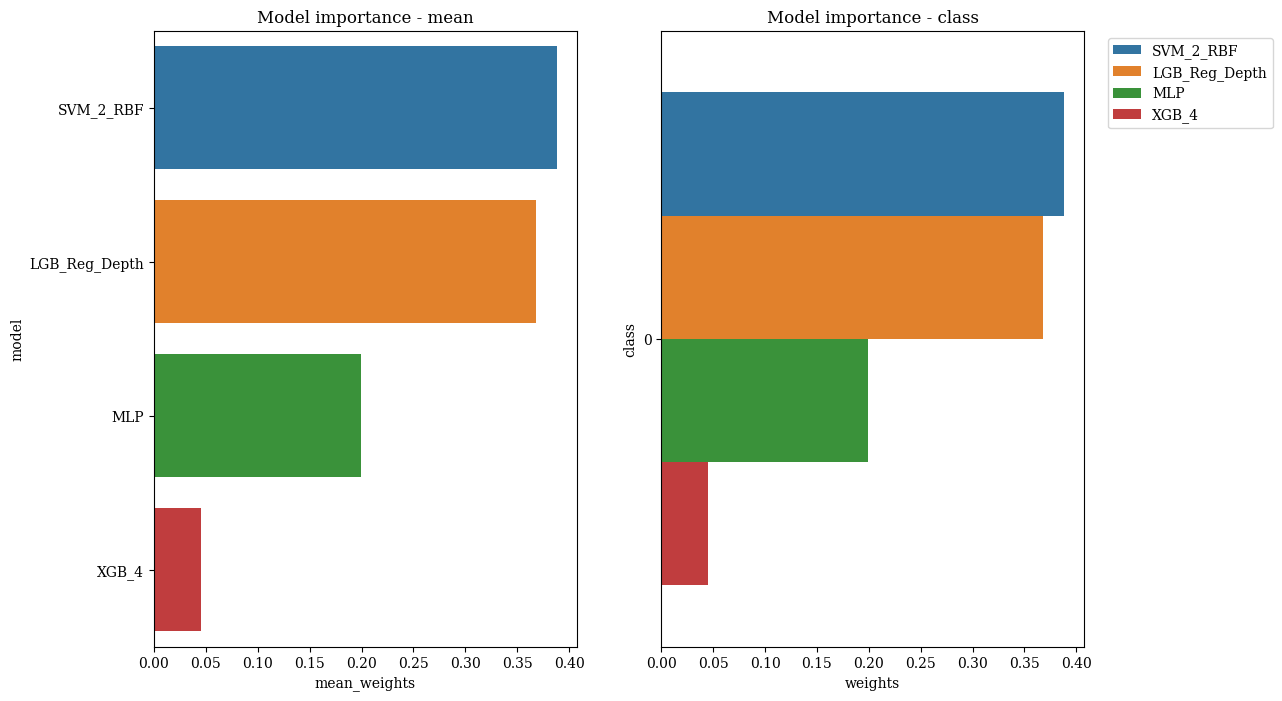

=========== Model Classes Importance ============
model
SVM_2_RBF        0.388
LGB_Reg_Depth    0.368
MLP              0.199
XGB_4            0.045
Name: weights, dtype: float32
                     weights
class model                 
0     SVM_2_RBF        0.388
      LGB_Reg_Depth    0.368
      MLP              0.199
      XGB_4            0.045
=========== Feature Importance ============


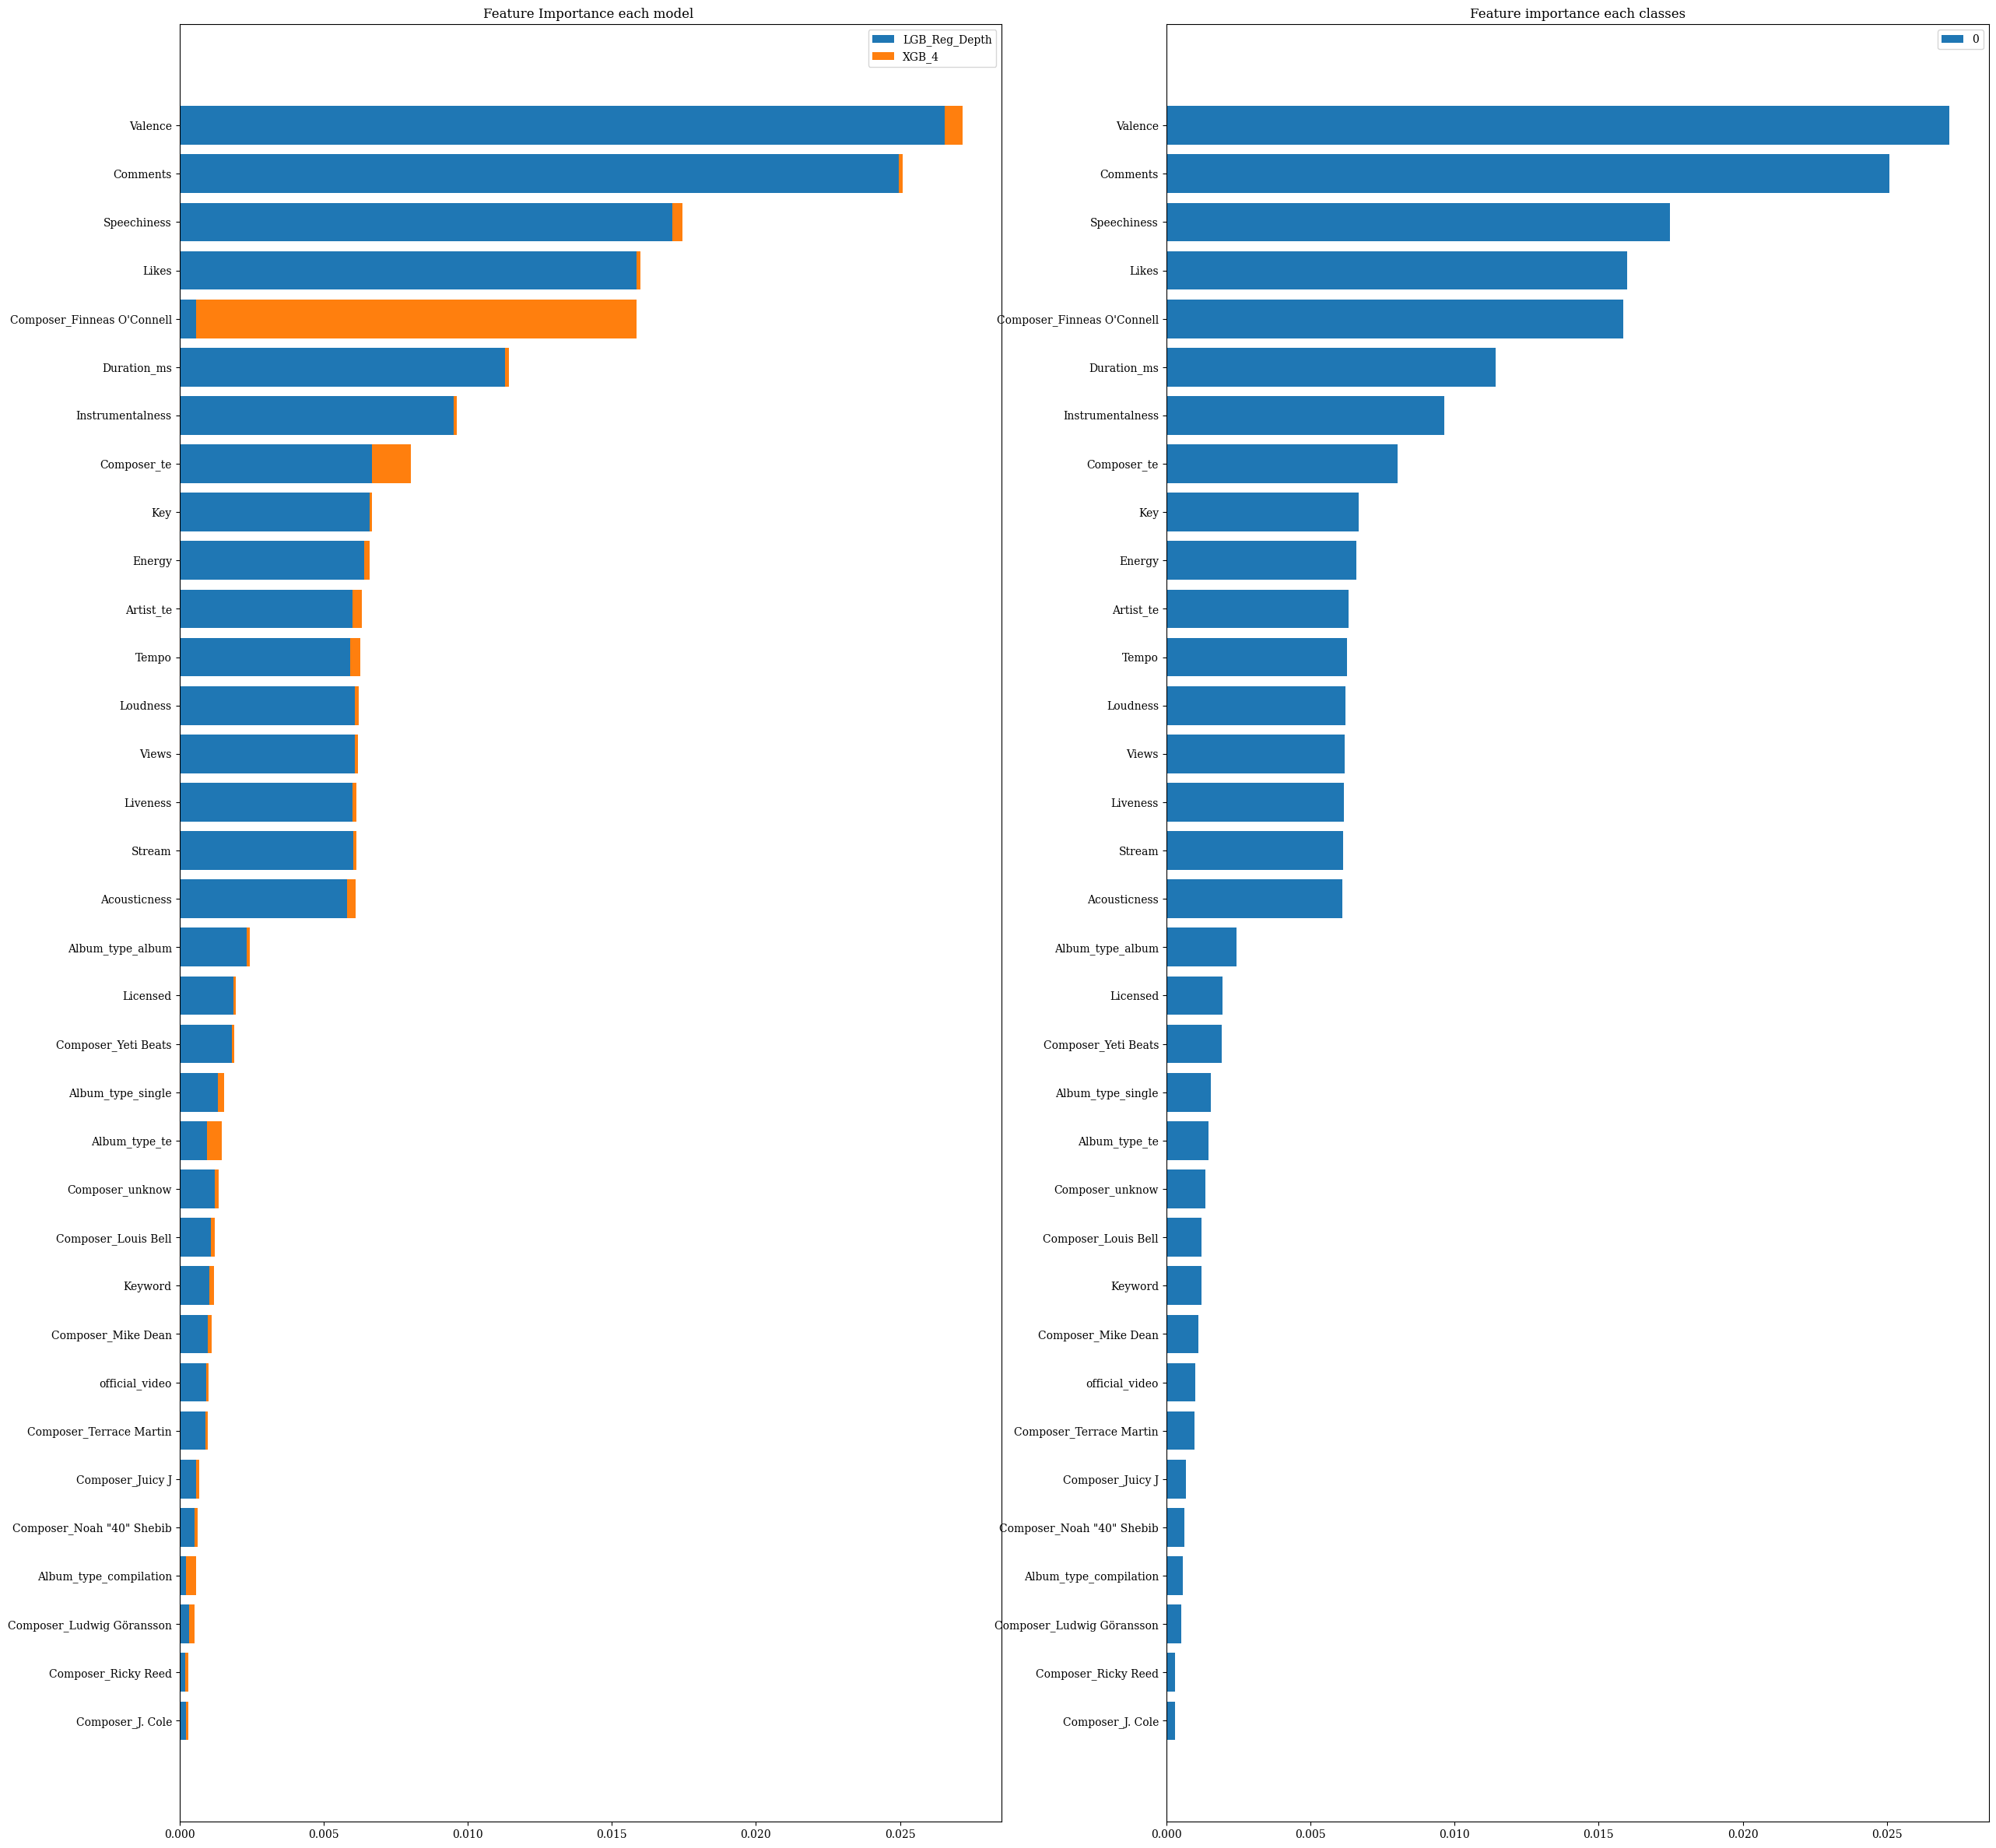

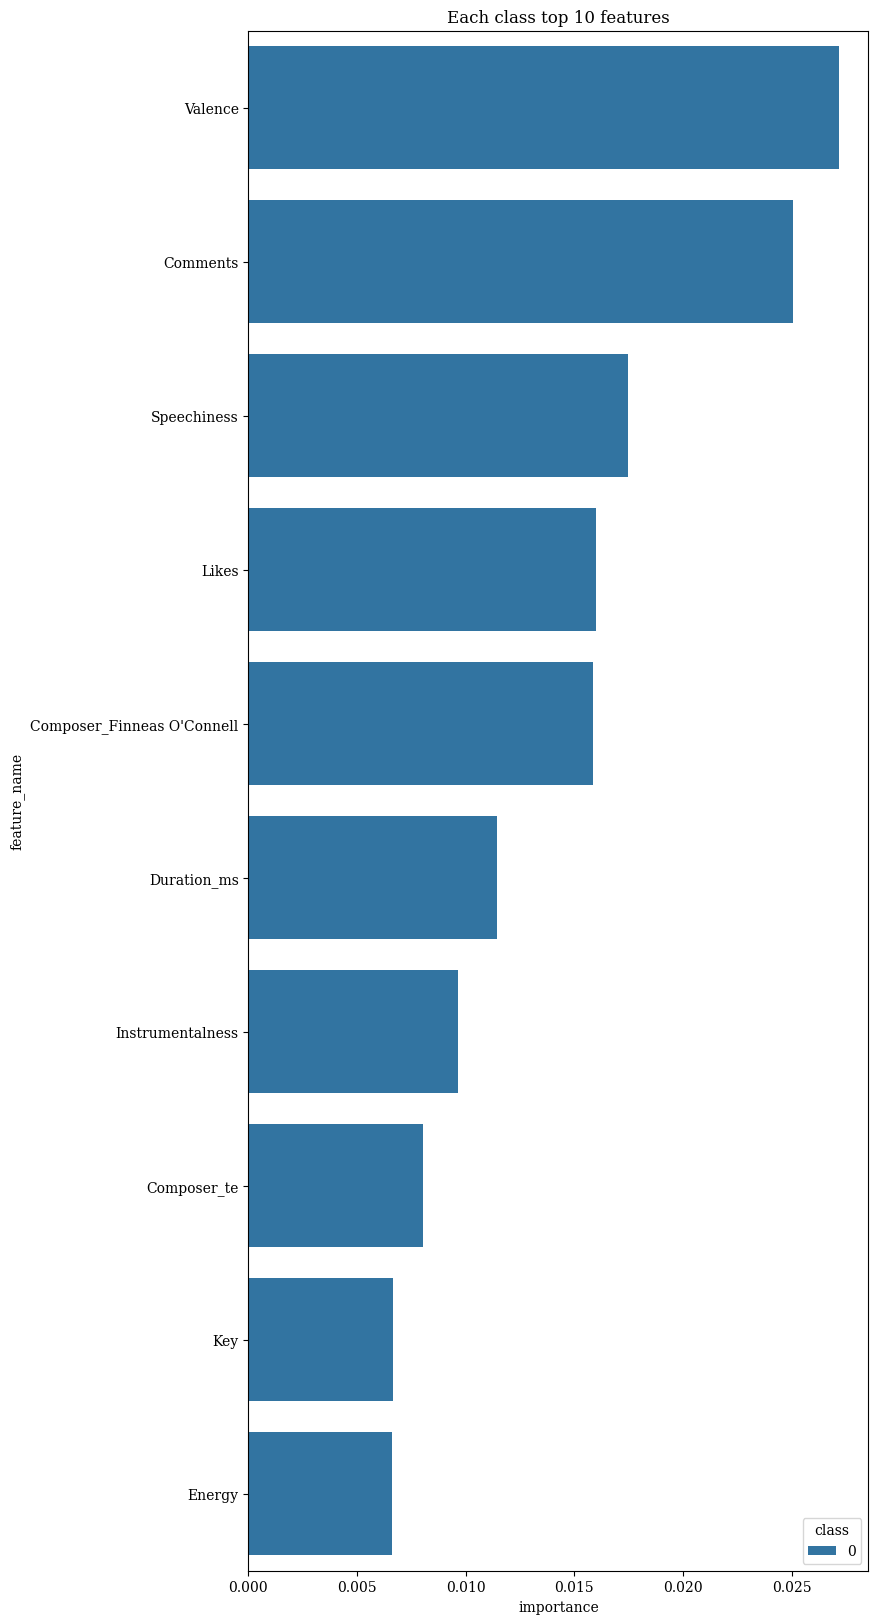

  class                feature_name  importance  mean_importance
0     0                     Valence    0.027172         0.027172
1     0                    Comments    0.025080         0.025080
2     0                 Speechiness    0.017462         0.017462
3     0                       Likes    0.015993         0.015993
4     0  Composer_Finneas O'Connell    0.015866         0.015866
5     0                 Duration_ms    0.011436         0.011436
6     0            Instrumentalness    0.009633         0.009633
7     0                 Composer_te    0.008027         0.008027
8     0                         Key    0.006675         0.006675
9     0                      Energy    0.006593         0.006593


In [8]:
stacking_analysis_df = weighted_stacking_analysis(model, feature_columns)

In [9]:
def adjusting_error(df,threshold=0.4):
    df['diff'] = (df[label_column].apply(lambda x: (x+0.5)//1) - df[label_column])
    df['diff']=df['diff']*(df['diff'].abs()<=threshold).astype(int)
    
    df[label_column]  += df['diff']
    df = df.drop(columns=['diff'])
    return df
def post_process(df, adjusting_threshold=0.4):
    df[label_column] = df[label_column].apply(lambda x: 0 if x<0 else x).values
    
    df = adjusting_error(df,adjusting_threshold)
    return df

In [10]:
eval_dict = model.evaluate(val_df[feature_columns],val_df[label_column], evaluation_fn = mean_absolute_error)
pred = eval_dict['model_predict']['Ensemble Model']
_df = pd.DataFrame()
_df['id'] = val_df.id
_df[label_column] = pred
_df = post_process(_df)
mean_absolute_error(_df[label_column],val_df[label_column])

            model  eval_metric
0   LGB_Reg_Depth     0.649535
1           XGB_4     0.899786
2  Ensemble Model     1.387842
3             MLP     1.939160
4       SVM_2_RBF     1.955219


1.3876835178176499

In [11]:
_,model_predict_dict= model.model_predicts(test_df[feature_columns])
pred =model_predict_dict['Ensemble Model']

In [ ]:
submit_df = pd.read_csv('./data/regression_example/html2023-spring-final-project/sample_submission.csv')
submit_df.loc[submit_df.id.isin(test_df.id),label_column] = pred
submit_df.loc[submit_df.id.isin(val_df.id),label_column] = val_df[label_column].values
submit_df = post_process(submit_df)
submit_df.to_csv('submission.csv',index=False)
    